In [2]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

# Datasets in PyTorch

With the objective to decouple the codes of loading/preprocessing data and training on data, there are two data primitives in PyTorch:
- [`torch.utils.data.Dataset`]():  it stores the samples and their corresponding labels.
- `torch.utils.data.DataLoader`:  It wraps an iterable around the Dataset to enable easy access to the samples.

In addition, Pytorch provides modules for easily downloading and working with many famous datasets. 

You can find PyTorch's built-in datasets here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

Examples:
- `torchvision.datasets.CIFAR10`
- `torchtext.datasets.IMDB`
- `torchaudio.datasets.SPEECHCOMMANDS`

All of them are inherited from `torch.utils.data.Dataset`.


In [3]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST(root = '~/.pytorch/MNIST_data/', download=True, train=True, transform=transform) # target_transform
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

36.0%

100.0%


Extracting C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw


100.0%


Extracting C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw




100.0%
100.0%


Extracting C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw

Extracting C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\abbasi/.pytorch/MNIST_data/MNIST\raw



Note: 


`~/` means the user's home directory.

For example:

`~/.pytorch/MNIST_data/` ==> `C:\Users\ashkan/.pytorch/F_MNIST_data/`<br>
`~/.keras/datasets` ==> `C:\Users\ashkan\.keras\datasets`<br>
`~/Anaconda3` ==> `C:\Users\ashkan\Anaconda3`<br>

In Windows, only PowerShell recognizes this shortcut. 

### The content of `torch.utils.data.Dataset`'s object can be accessed by indexing

All datasets are subclasses of `torch.utils.data.Dataset` i.e, they have `__getitem__` and `__len__` methods implemented. 

The `__getitem__` function loads and returns a sample from the dataset at the given index.

In [4]:
image, label = trainset[0]
print(image.shape)
print(label)
print(len(trainset))

torch.Size([1, 28, 28])
5
60000


### Wrap an iteratable around Dataset object

`trainloader` wraps an iterator around `trainset`. 

--------
*Extra*: What is an iterator?

```python
# An iterator is an object which implements __iter__() and __next__().
class myCounter:
    def __iter__(self):
        self.counter = 1
        # must always return the iterator object itself.
        return self

    def __next__(self):
        # must return the next item in the sequence.
        out = self.counter
        self.counter += 1
        return out


counter_object = myCounter()
counter = iter(counter_object) # get an iterator

print(next(counter))
```
-------
Using `trainloader`, we can easily get an iterator from it (`iter(trainloader)`). Later, we'll use this iterator to loop through the dataset for training, like

```python
for image, label in trainloader:
    ## do things with images and labels
```

In general, subclasses of `torch.utils.data.Dataset` can be passed to a `torch.utils.data.DataLoader` which can load multiple samples in parallel using `torch.multiprocessing` workers. 


For example:

```python
imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)
```

In [5]:
dataiter = iter(trainloader) # iter(.): returns an iterator for the given object. 
# Note: The object should be iteratable.
#       Most built-in containers in Python like: list, tuple, string etc. are iterables.

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


### Transforms

**Note: Generally, transforms need images with size of C x H x W and they return a list.**
   ```python
   # Example - The following piece of code can be used inside a __get_item__ method for a custom Dataset.
   imt = torch.from_numpy(self.vol[index, :, :])        # Original image as a Pytoch Tensor of size 200x1024
   item = np.expand_dims(imt, axis=0)                   # 200x1024 => 1x200x1024
   image = self.transforms(teim)[0]                     # The output is a Torch tensor with a size of 1x200x1024
   ```

[ToTensor](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) Convert a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to tensor (torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]) - SCALING

[Normalize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize) a tensor image with the given mean and standard deviation. This transform does not support PIL Image.

`transforms.Normalize` computes the following for each channel: 
$$image = \frac{image - \mu}{\sigma}$$

`transforms.Normalize((0.5,), (0.5,))` ==> 
It will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1. You perform it with the hope that the distribution becomes nearly standard normal distribution with mean of 0 and a variance and standard deviation of 1.

This is what one of the images looks like. 

In [6]:
print(images[1].numpy().shape) 
print(images[1].numpy().squeeze().shape)
print(np.expand_dims(images[1].numpy().squeeze(), axis = 0).shape)

(1, 28, 28)
(28, 28)
(1, 28, 28)


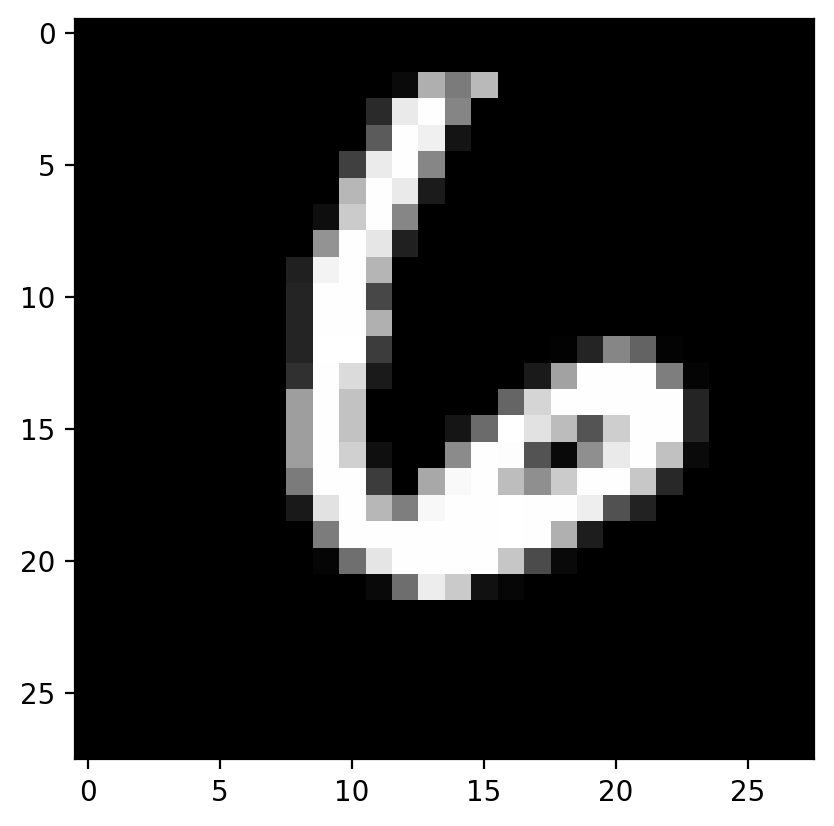

In [7]:
plt.imshow(images[1].numpy().squeeze(), cmap=plt.cm.gray); # images[1,:,:,:]

# Custom datasets

```python
class CustomImageDataset(torch.utils.nn.Dataset):
    def __init__(self, ...):
        ...
    def __len__(self):
        ...
    def __getitem__(self, index):
        ...
```

Example: 
    
- [Dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

# More Readings

ToDo
- [ ] More examples on how to use transforms.
- [ ] [A detailed example of how to generate your data in parallel with PyTorch](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-d)

- [DATASETS & DATALOADERS](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
- [TRANSFORMS](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html#transforms)